# WR template in pyHarm

This notebook is bult in order to provide a example into how to implement WR as a connector in pyHarm.

- Single connector that grabs 3 dofs (slave, master, force) : 
    - modify residual in order to obtain the WR effect
    - Just set the force dofs as being nonlinear
- In the input, add a `force_dof` as a `onlydofs` substructure that will hold the necessary dofs

**/!\ : NEED PYHARM >= 1.1.2 to work [current release is 1.1.3]**

In [1]:
import pyHarm
import numpy as np
from pyHarm.BaseUtilFuncs import pyHarm_plugin # to dynamically plug any changes to the created class in the notebook
TEST = True

# buld simple one dof linear system : 

M = np.ones((1,1))
K = 1e2*np.ones((1,1))
C = 1e-1 * np.ones((1,1))

sub_d = dict(
    onedof = dict(
        type = 'substructure',
        matrix = dict(
            M=M,
            K=K,
            C=C
        ),
        ndofs=1 # number of dof per node
    ),
    wrforces = dict( # this is only needed for the WR case 
        # (note : ok for testing/bench/dev, in prod need dynamic creation of dof when WR elemetns are instanciated)
        type = 'onlydofs',
        nnodes = 1,
        ndofs=1, # number of dof per node
        nmodes=0 # number of dof per node
    ),
)

sys_d = dict(
    type='Base',\
    nh = [1],
    nti = 2**6
)

from pyHarm.Systems.FactorySystem import generateSystem

test_sys = generateSystem(
    name_system='Base',
    datas=dict(substructures=sub_d, system=sys_d)
)
# THE LOG BEHAVING WEIIIRD is normal ... well not really is a bug due to kernel not being restarded in juyter notebooks
test_sys.edf # this shows what dofs are in your system !

[   INFO   ] -- 10:10:01 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    4     |
                         |Substructures|Parts |    2     |
                         |Connectors|Elements |    1     |
                         |     Kinematics     |    0     |
                         |     Harmonics      |   [1]    |
                         |     Time steps     |    64    |



,sub,harm,cs,node_num,dof_num,PoM,NL,KC
0,onedof,1,c,0,0,p,0,0
1,wrforces,1,c,0,0,p,0,0
2,onedof,1,s,0,0,p,0,0
3,wrforces,1,s,0,0,p,0,0


In [2]:
# run the linerar system by adding some forcing

forcing = dict(
    type='CosinusForcing',
    connect=[('onedof',[0]), ('GROUND',[0])], # this is the new way of writing "connect" keyword from 1.1.x that allows more than 2 declaration --> GROUND and INTERNAL are reserved namespace you cannot calla a subtructure with those names
    dirs=[0],
    amp=1.0
)

wrforces_lock = dict(
    type='DispImposed',
    connect={"wrforces":[0]}, # this is the old way [yet to be updated .. new way not working yet for kinematics i think],
    dirs=[0],
    amp=1.0
)

DELTA_PULS = 3.0
PULS_SUP, PULS_INF = float(np.sqrt(K/M)) + DELTA_PULS, float(np.sqrt(K/M)) - DELTA_PULS
MIN_NBP = 100
DS_MAX = (PULS_SUP-PULS_INF)/MIN_NBP
frf = dict(
    study="frf",
    puls_inf = PULS_INF,
    puls_sup = PULS_SUP,
    ds_max = DS_MAX,
    ds_min = DS_MAX * 2**(-8)

)

whole = dict(
    substructures=sub_d,
    system=sys_d,
    connectors=dict(forcing=forcing),
    kinematics=dict(wrforces_lock=wrforces_lock),
    analysis=dict(FRF=frf)
)

L = pyHarm.Maestro(
    idata=whole
)
L.operate()

# we need to add something on the last dof for hte linear system otherwise ... not happy with the matrices : 
# here a kinematic condition forcing wrforces=1 --> THIS IS JUST FOR LINEAR

C:\Users\d615868\AppData\Local\Temp\ipykernel_15140\1896807024.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  PULS_SUP, PULS_INF = float(np.sqrt(K/M)) + DELTA_PULS, float(np.sqrt(K/M)) - DELTA_PULS

######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
#############

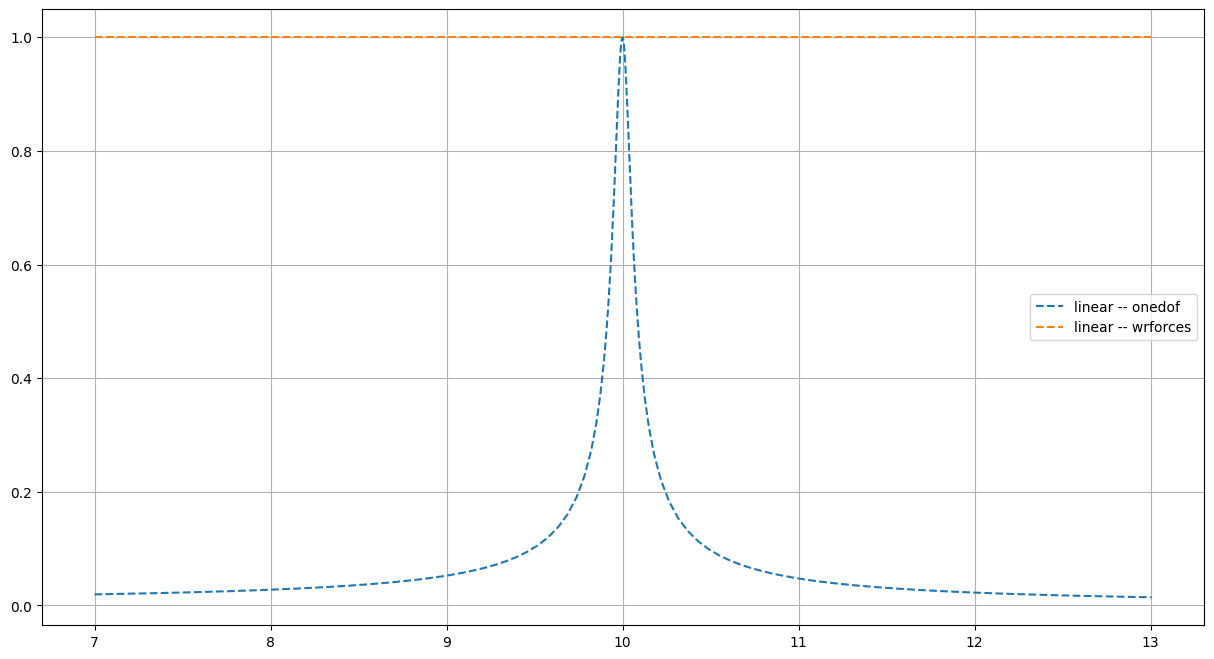

In [3]:
from HelperFunctions import get_frf, prep_fig

dofpost = dict(
    onedof = dict(sub='onedof', node=0, direction=0),
    wrforces = dict(sub='wrforces', node=0, direction=0),
)
for key, values in dofpost.items() : 
    dofpost[key]['frf_linear'] = get_frf(M=L, **values)

fig,ax = prep_fig()
for key, values in dofpost.items() : 
    ax.plot(
        *dofpost[key]['frf_linear'],
        label=f"linear -- {key}",
        linestyle='--'
    )
ax.legend()

# THIS IS WHERE WE START IMPLEMENTING THINGS

In [4]:
# buid the new connector that does ... whatever but takes 3dofs using the grabbers
from pyHarm.DofGrabber import dof_grabber
if TEST :  
    index_forces = dof_grabber(
        edf=test_sys.edf,
        sub="wrforces",
        node=0,
        dof=0
    )
    print(test_sys.edf.loc[index_forces])
#### comment : there is a bunch of grabbing functions for getting all the dofs from a node, etc ... all in DofGrabber module



        sub  harm cs  node_num  dof_num PoM  NL  KC
1  wrforces     1  c         0        0   p   0   0
3  wrforces     1  s         0        0   p   0   0


## WRElement class : 
inherits from NodeToNodeelement class but reimplement the wya of getting nodes and stuff -- this is is just to avoid having to do that stuff later on for all WR element.

This class remmain being an ABSTRACT CLASS so you cannot instanciate those yet !

In [5]:
from pyHarm.Elements.NodeToNodeElements.NodeToNodeElement import NodeToNodeElement
import pandas as pd 
from pyHarm.DofGrabber import gen_NodeToNode_select_matrix
class WRElement(NodeToNodeElement):

    def generateIndices(self, expl_dofs: pd.DataFrame):
        """From the explicit dof DataFrame, generates the index of dofs concerned by the connector.
        
        Args:
            expl_dofs (pd.DataFrame): explicit dof DataFrame from the studied system.

        Attributes:
            indices (np.ndarray): index of the dofs that the connector needs.
            Pdir (np.ndarray): a slice of first dimension is a transformation matrix to a direction in local coordinate system.
            Pslave (np.ndarray): selection array that selects the slave dofs of the connector.
            Pmaster (np.ndarray): selection array that selects the master dofs of the connector.
            Pforce (np.ndarray): selection array that selects the force dofs of the connector.
        """
        _indices, _Pmat = gen_NodeToNode_select_matrix(edf=expl_dofs, input_dict=self.data)
        _components = expl_dofs.loc[_indices]['dof_num'].unique()
        self.indices = _indices
        self.Pslave, self.Pmaster, self.Pforce = _Pmat[0:3] # selection of the three first matrices
        self.Pdir = self._gen_Pdir(_components)
    pass

In [88]:

def _residual_function(x:np.ndarray,om:float,
                       Pmaster:np.ndarray, Pslave:np.ndarray, Pforce:np.ndarray, Pdir:np.ndarray,
                       DFT:np.ndarray, DTF:np.ndarray,
                       *args) -> np.ndarray:
    # if you code this using `jax.numpy` instead of simple numpy you can get easy the jacobian by autodiff 
    # residual can also be JIT using either NUMBA or JAX (use JAX JIT if function is using jax.numpy)
    R = np.zeros(x.shape)
    x_slave = Pdir[0,:,:] @ Pslave @ x # Pdir contains the DIRECTIONS -- here hard coded PDir[0,:,:] but not viable in prod
    x_master = Pdir[0,:,:] @ Pmaster @ x
    x_force = Pdir[0,:,:] @ Pforce @ x
    # DO YOUR THING AROUND THERE
    ForceHUH = x_force - 1/2.*x_slave
    ForceHAH = x_slave

    # REPROJECT RESIDUAL IN THE RESIDUAL VECTOR : 
    R +=  (Pforce.T) @ Pdir[0,:,:].T @ ForceHUH
    R +=  (Pslave.T - Pmaster.T) @ Pdir[0,:,:].T @ ForceHAH
    return R

######################################### START SOME BONUS CODING
def _jax_jacobian(*args) : 
    import jax
    _jax_jaco = jax.jit( # JIT for compilation at run time (speed-up)
        jax.jacfwd(
            _residual_function
        )
    )
    return _jax_jaco(*args)

def _jacobian_function(*args,**kwargs) -> tuple[np.ndarray, np.ndarray]: # this should become your analytical jacobian
    pass
######################################### END SOME BONUS CODING

class fakeWR(WRElement) : 
    factory_keyword : str = "fakeWR" # this is important as this is how you call the new element from input dict !

    def __post_init__(self,):
        # all your parameters gets init here
        self.jacobian_function = self._jacobian_selection() # if you have coded anlytical or other jacobian functinos
        self.nabo = np.linalg.matrix_power(self.nabla,0) # if you need derivatives
    
    def adim(self, lc, wc):
        # THIS IS MANDATORY METHOD AND HAS TO BE DONE PROPERLY BEFORE MERGING --> ok to skip for testing
        self.flag_adim = True
        
    pass

    def _jacobian_selection(self,):
        if "jac" in self.data.keys():
            return _jacobian_function
        else:
            return self._evalJaco_DF

    def evalResidual(self, xg, om, Rglin=None):
        x = xg[self.indices]
        self.R = _residual_function(x, om,
                                    Pmaster=self.Pmaster, Pslave=self.Pslave, Pforce=self.Pforce,
                                    Pdir=self.Pdir,
                                    DFT=self.D['ft'], DTF=self.D['tf'])
        return self.R
    
    def evalJacobian(self, xg, om):
        dJdx, dJdom = self.jacobian_function(xg, om, step=1e-5) # we use finite diff here to simplify testing, but later on analytical or autodiff could be great
        self.J = dJdx
        self.dJdom = dJdom
        return self.J,self.dJdom
    
# NOW we plug the new class 
pyHarm_plugin(fakeWR)

In [89]:
import copy
whole_with_wr = copy.deepcopy(L.inputData)
whole_with_wr.pop("kinematics") # we dont need this now
wrconnector = dict(
    type=fakeWR.factory_keyword,
    connect=[('onedof',[0]),('GROUND',[0]),('wrforces',[0])],
    dirs=[0],
    everything_you_need=0.0
)
whole_with_wr['connectors'] = whole_with_wr['connectors'] | dict(wrconnector=wrconnector)

WR = pyHarm.Maestro(whole_with_wr)
WR.operate("null")


######################################################
##                                                  ##
##                                                  ##
##                  _   _                           ##
##      _ __  _   _| | | | __ _ _ __ _ __ ___       ##
##     | '_ \| | | | |_| |/ _` | '__| '_ ` _ \      ##
##     | |_) | |_| |  _  | (_| | |  | | | | | |     ##
##     | .__/ \__, |_| |_|\__,_|_|  |_| |_| |_|     ##
##     |_|    |___/                      v-1.1.3    ##
##                                                  ##
##                                                  ##
######################################################
    python      :   3.13.2              
    licence     :   Apache 2.0 - open-source
    extensions  :   


[   INFO   ] -- 10:27:13 -- # SYSTEM INITIALIZED :
                         |  Total dof number  |    4     |
                         |Substructures|Parts |    2     |
                         |Connectors|Elements |    3     |
  

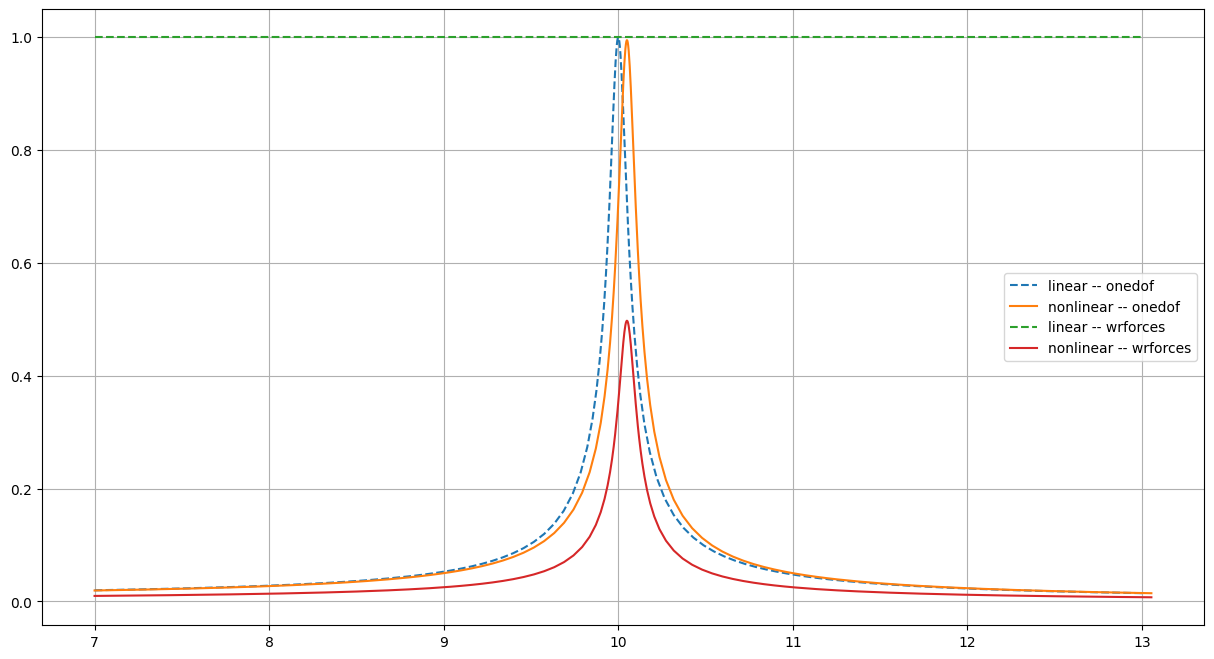

In [90]:
for key, values in dofpost.items() : 
    dofpost[key]['frf_nl'] = get_frf(M=WR, **values)

fig,ax = prep_fig()
for key, values in dofpost.items() : 
    ax.plot(
        *dofpost[key]['frf_linear'],
        label=f"linear -- {key}",
        linestyle='--'
    )
    ax.plot(
        *dofpost[key]['frf_nl'],
        label=f"nonlinear -- {key}",
    )
ax.legend()